<h1><center>ALCX Price vs ALCX Accounts</center></h1>
<center>How does the adoption of Alchemix impact price?</center>

@Ryanl

Quick thanks to @flipsidecrypto for the bounty

<h2>Data</h2>
Using Flipside's VELOCITY database, I created an SQL query (https://app.flipsidecrypto.com/shareable/adoption-and-price-J6iI1y) which allowed me to grab the number of unique ALCX wallets and ALCX price over time ranging from February 27, 2021 - April 11, 2021. Data used in the following analysis is all real-time data, based on a VELOCITY query which updates daily. Downloading the notebook and running locally would yield different results than what is shown below, as more data would be available. 

<h2>Analysis</h2>
<h3>Imports</h3>

In [1]:
import urllib.request as rq
import json
from datetime import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics

The main library used for this analysis is sklearn's linear regression module which allowed me to run linear regressions between three variables: price, ALCX accounts and time. The below code was used to grab the data from Flipside's API which imports the data in JSON as a list of dictionaries which I then converted to a pandas dataframe.

In [2]:
url = 'https://api.flipsidecrypto.com/api/v2/queries/4bf360e8-97ad-490f-b147-7024dffb139f/data/latest'

try:
    dataset = rq.urlopen(url)
    dataset = dataset.read()
    dataset = json.loads(dataset)
    dataset = pd.DataFrame(dataset)
except Exception as e:
    print('Unable to get data from flipsidecrypto API. Check the URL below: \n{}'.format(url))


The next code block creates 3 additional series to the dataset: 
- change in price
- change in unique addresses
- incrementing integers that represent number of days after launch
These two series are used to plot the first figure below.

In [ ]:
#delta_price = [0]
#delta_addresses = [0]
ind = [0]
counter = 0
while counter < len(dataset)-1:
    ind.append(counter)
    dataset['BALANCE_DAY'][counter] = dataset['BALANCE_DAY'][counter].rsplit('T')[0]
    counter+=1
dataset['BALANCE_DAY'][counter] = dataset['BALANCE_DAY'][counter].rsplit('T')[0]
dataset['IND'] = ind
dataset['DELTA_PRICE'] = np.gradient(dataset['PRICE'])
dataset['DELTA_ADDRESSES'] = np.gradient(dataset['UNIQUE_ADDRESSES'])

#del delta_addresses, delta_price, counter, ind

This next block utilizes a linear regression module to analyze the relationship between a couple different sets of data.

In [4]:
x = dataset.iloc[:,3].values.reshape(-1,1)
y1 = dataset.iloc[:,1].values.reshape(-1,1)
y2 = dataset.iloc[:,2].values.reshape(-1,1)
x1_change = dataset.iloc[:,5].values.reshape(-1,1)
y1_change = dataset.iloc[:,4].values.reshape(-1,1)
linear_reg = LinearRegression()
linear_reg.fit(x1_change,y1_change)
y_pred = linear_reg.predict(x1_change)
linear_reg2 = LinearRegression()
linear_reg2.fit(x,y2)
y_pred2 = linear_reg2.predict(x)
lin_reag3 = LinearRegression()
lin_reag3.fit(y2,y1)
y_pred3 = lin_reag3.predict(y2)

<h3>ALCX Accounts vs Time</h3>
Below we can see the relationship between the number of unique accounts with respect to time. 

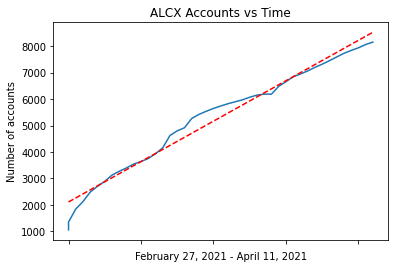

In [5]:
fig,ax = plt.subplots()
plt.plot(x,y2,label='accounts (USD)')
plt.plot(x,y_pred2,color='r',linestyle='dashed')
ax.axes.xaxis.set_ticklabels([])
plt.xlabel('February 27, 2021 - April 11, 2021')
plt.ylabel('Number of accounts')
plt.title('ALCX Accounts vs Time')
plt.show()

Figure 1 - ALCX Accounts over Time

In [12]:
print('R-squared:{:.2f}'.format(metrics.r2_score(y2,y_pred2)))
print('Slope:{}'.format(linear_reg2.coef_))

R-squared:0.97
Slope:[[152.68346056]]


The above model's R-squared value shows that it is a good predictor for the observed data. On average, we can say that there will roughly be an increase of 153 new addresses per day.

<h3>Change in Price/Unique Accounts of ALCX vs Time</h3>
See the following figure which shows the change in price and change in number of unique addresses with respect to time. From this graph, we can see that there is some correlation between the change in price and the change in unique accounts. From the graph, we can see that the maximas of the two series tend to line up, meaning that during a price surge, there will also be a jump in unique ALCX accounts.

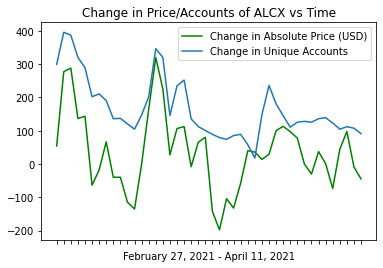

In [7]:
#plot
fig,ax = plt.subplots()
plt.plot(dataset['BALANCE_DAY'],dataset['DELTA_PRICE'],label='Change in Absolute Price (USD)',color='g')
plt.plot(dataset['BALANCE_DAY'],dataset['DELTA_ADDRESSES'],label='Change in Unique Accounts')
plt.legend(loc='best')
ax.axes.xaxis.set_ticklabels([])
plt.xlabel('February 27, 2021 - April 11, 2021')
plt.title('Change in Price/Accounts of ALCX vs Time')
plt.show()

Figure 2 - Change in Price/Change in accounts vs Time (ALCX)

To elaborate, the above figure only demonstrates the relationship between the deltas of price and unique accounts vs time. However, what we want to know is how these two variables relate to each other. 

<h3>Change in Price vs Unique Accounts of ALCX</h3>
The below code snippet prepares the data to be used in sklearn's linear regression model which requires data to be in numpy arrays. For graphing purposes, integer values were used to days (x axis) to simplify graphing and allow the data to fit in the regression model. Beginning at 0 for launch, and incrementing to the length of the data.

The below graph represents the price of ALCX vs the number of unique addresses.
From the below graph, we can see that the price of ALCX *tend* to increases with the amount of unique accounts. We can see near 3900 and 6000 accounts, there is a dip in price. However, we can see the overall trend of the data increase as the number of accounts.

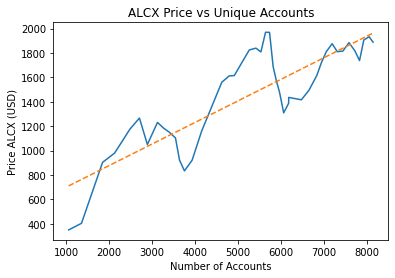

In [8]:
fig,ax = plt.subplots()
plt.plot(dataset['UNIQUE_ADDRESSES'],dataset['PRICE'],label='Unique Addresses')
plt.plot(y2,y_pred3,linestyle='dashed')
plt.xlabel('Number of Accounts')
plt.ylabel('Price ALCX (USD)')
plt.title('ALCX Price vs Unique Accounts')
plt.show()

Figure 3 - ALCX Price vs Unique Accounts

In [11]:
print("R-squared:{}".format(metrics.r2_score(y1,y_pred3)))
print("Slope:{}".format(lin_reag3.coef_))

R-squared:0.7218622480566586
Slope:[[0.17656733]]


We can see from the data above, that roughly **72%** of the variance in absolute ALCX price due to unique accounts can be explained by this linear model. Using this, we can say that the correlation between the price of ALCX has a positive relation due to the number of accounts. However, we are currently only looking at the larger picture. What does this mean with respect to their daily change?

<h3>Change in Price vs Change in Accounts (ALCX)</h3>
Below is a graph of the absolute change in price with respect to the absolute change in unique ALCX accounts. We can see from this graph, that there is much less linearity in the plot compared to the previous figures.

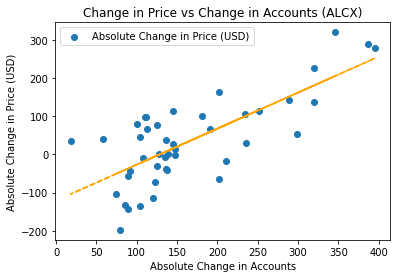

In [9]:
#plot
fig,ax = plt.subplots()
plt.scatter(x1_change,y1_change,label='Absolute Change in Price (USD)',marker='o')
plt.plot(x1_change,y_pred,color='orange',linestyle='dashed')
plt.legend(loc='best')
plt.xlabel('Absolute Change in Accounts')
plt.ylabel('Absolute Change in Price (USD)')
plt.title('Change in Price vs Change in Accounts (ALCX)')
plt.show()

Figure 4 - Change in Price vs Change in Accounts (ALCX)

In [10]:
print('R-squared:{:.2f}'.format(metrics.r2_score(y1_change,y_pred)))
print('Slope:{}'.format(linear_reg.coef_))

R-squared:0.55
Slope:[[0.94256288]]


We can see that this relationship gives an R-squared value of **0.55**. This model is not as accurate as the previous models, and this makes sense. The daily change in price seems to have a lower corelation to the change in unique accounts compared to previous graphed data. As our scope narrows, the relationship is harder to characterize linearly to the point where the model's  change in price predictions is only 50% accurate. Each of these deltas are taken by day, which means that there is day-by-day variability in price that the change in users doesn't account for.

This is interesting to note, but not surprising. This analysis only takes into account the price and adoption of ALCX. Countless other factors, most notably market trends, were not taken into account which most likely has a larger impact on the change in price. 

<h2>Conclusion</h2>
Since the launch of ALCX, we can see that there has been continuous strong adoption over time that seems to follow the predicted trends quite closely at 97% (Figure 1). As we relate this to price, there is a strong positive association between price and accounts with a *predicted* $1 increase in price for every additional ~5 unique Alchemix accounts. With a *predicted* increase of ~153 new addresses per day, we should continue to see a rise in price.

However, narrowing our scope even more, we can see that the modelling for Figure 4, is only 55% accurate for the day-to-day changes. Unfortunately, it is not as strong of a model as the previous. The change in price due to the change in number of accounts varies quite a bit. 

This shows that as we narrow the scope of our data, we can see that the relationship grows weaker. This is due to the limitations of the scope of which this analysis was based. There are many other variables that would affect adoption as well as price. To name a few, media attention (Bounty question #13: ALCX & Twitter) and current market trends and comparison to other DeFi platforms are also needed to assess the full reasoning behind price changes.

<h2>Limitations</h2>
<h3>Amount of Data Available</h3>
As Alchemix was only launched on February 27, these linear regression models are based on only 44 data points which I'd argue isn't enough to accurately predict future outcomes.